In [1]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras import layers, losses
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from enum import Enum
import PIL
import PIL.Image
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.layers import UpSampling2D
from PIL import Image
from tensorflow.keras.layers import BatchNormalization
import random

2023-12-03 14:13:06.821170: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 14:13:06.839846: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 14:13:06.983353: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 14:13:06.984619: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 14:13:07.806168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# GLOBAL VARIABLES 
os.chdir("/home/linus/WashUCoding/DIS Copenhagen/Neural Networks/TomJerryProject")
print("Working Directory:", os.getcwd())
# directories containing desired output, i.e. our y-labels, the ground truth 
outputDirectories = ["tom_jerry_object_detected/ObjectDetectedDataset/"]
                    #  "archive/tom_and_jerry/tom_and_jerry/tom", 
                    #  "archive/tom_and_jerry/tom_and_jerry/tom_jerry_0",
                    #  "archive/tom_and_jerry/tom_and_jerry/tom_jerry_1"]

# directories containing edge-filtered images
inputDirectories = ["tom_jerry_object_detected/ObjectDetectedDataset_edge_detected/"]
                    # "archive/tom_and_jerry/tom_and_jerry_edge_detected/tom_edge_detected", 
                    # "archive/tom_and_jerry/tom_and_jerry_edge_detected/tom_jerry_0_edge_detected",
                    # "archive/tom_and_jerry/tom_and_jerry_edge_detected/tom_jerry_1_edge_detected"]

Working Directory: /home/linus/WashUCoding/DIS Copenhagen/Neural Networks/TomJerryProject


In [3]:
# HELPER FUNCTIONS
""" Returns file paths for all images in the input and output directories

    Returns:
        List(Tuples): each tuple contains paths to two corresponding images, the first is the edge-filtered image, the second is the unaltered image
"""
def getFilePaths(): 
    dataset = []
    for inputDir, outputDir in zip(inputDirectories, outputDirectories): 
        fileNames = os.listdir(inputDir)
        for fileName in fileNames: 
            inputImagePath = os.path.join(inputDir, fileName)
            outputImagePath = os.path.join(outputDir, fileName)
            dataset.append((inputImagePath, outputImagePath))
    return dataset

""" Returns two images as two numpy arrays, normalized by dividing by the image's by 128

    Args: 
        input_file_path (str): path to an edge-filtered image
        output_file_path (str): path corresponding to the un-modified image of the input_file_path
        image_shape Tuple(int, int): desired width and length of the image
        showImages (boolean): whether to display both images using matplotlib
        isRGB (boolean): whether to convert

    Returns: 
        (np.array, np.array): Two normalized numpy arrays, representing two images
"""
def loadImage(input_file_path, output_file_path, 
              image_shape=(400, 200), showImages=False, isRGB = True): 

    input_image = Image.open(input_file_path).resize(image_shape)
    output_image = Image.open(output_file_path).resize(image_shape)
    beforeGrayScale = np.array(input_image)
    # print("Inside loadImage():", np.min(beforeGrayScale), np.max(beforeGrayScale))

    # convert to greyscale if desired
    if not isRGB: 
        input_image = input_image.convert("L")
        output_image = output_image.convert("L")

    # if desired, display the retrieved images
    if showImages: 
        # Display images for testing
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(np.array(input_image))
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(np.array(output_image))
        plt.title("Ground Truth Image")
        plt.axis('off')

        plt.show()
    # for some reason, max pixel value from edge_detected images is 118.0
    return np.array(input_image)/118.0, np.array(output_image)/255.0


In [4]:
paths = getFilePaths()
maxesOfInput = []
maxesOfOutput = []
# for i in range(len(paths)): 
#     randomNum = random.randint(0, len(paths)-1)
#     result = loadImage(paths[randomNum][0], paths[randomNum][1], image_shape=(28,28), showImages=False, isRGB=False)
#     maxesOfInput.append(np.max(result[0]))
#     maxesOfOutput.append(np.max(result[1]))
    # print(np.min(result[0]), np.max(result[0]))
    # print(np.min(result[1]), np.max(result[1]))
# print(max(maxesOfInput))
# print(max(maxesOfOutput))


In [5]:
# CREATION OF TRAINING AND TESTING DATASETS

# randomize paths so images are randomly allocated into training/testing datasets
random.shuffle(paths)
validation_split = 0.2

x_train, y_train = [], []
x_test, y_test = [], []

imagesProcessed = 0
totalImagePairs = len(paths)

# THIS VARIABLE AFFECTS THE DIMENSIONS OF ALL IMAGES IN THE DATASET
# IT WILL ALSO AFFECT THE SHAPE OF THE AUTO_ENCODER
personal_image_shape = (128, 128)
for inputImagePath, outputImagePath in paths: 
    inputImage, imageLabel = loadImage(inputImagePath, 
                                       outputImagePath, 
                                       image_shape=personal_image_shape, 
                                       isRGB=False)

    # if validation_split = 0.2, put 80% of images into the training dataset
    if imagesProcessed / totalImagePairs > validation_split: 
        x_train.append(inputImage)
        y_train.append(imageLabel)
    # else, put the images into the testing dataset
    else: 
        x_test.append(inputImage)
        y_test.append(imageLabel)
        
    imagesProcessed += 1


# print(np.min(result[0]/255.0), np.max(result[0]/255.0))
# print(np.min(result[1]/255.0), np.max(result[1]/255.0))

In [6]:
# Confirming sizes of datsets and shapes of the datasets
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

820 820
206 206
(820, 128, 128)
(820, 128, 128)
(206, 128, 128)
(206, 128, 128)


In [7]:
# following guidance from the below link
# https://www.tensorflow.org/tutorials/load_data/numpy
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [8]:
# # MY VERSION

# class UNet(tf.keras.Model):
#     def __init__(self):
#         super(UNet, self).__init__()
#         self.encoder = tf.keras.Sequential([
#             Conv2D(8, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             Conv2D(8, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             MaxPooling2D((2, 2)),
#             Conv2D(16, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             Conv2D(16, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             MaxPooling2D((2, 2)),
#             Conv2D(32, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             Conv2D(32, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             MaxPooling2D((2, 2)),
#         ])
#         self.middle = Conv2D(64, (3, 3), activation='relu', padding='same')
#         self.decoder = tf.keras.Sequential([
#             UpSampling2D((2, 2)),
#             Conv2D(32, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             Conv2D(32, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             UpSampling2D((2, 2)),
#             Conv2D(16, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             Conv2D(16, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             UpSampling2D((2, 2)),
#             Conv2D(8, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             Conv2D(8, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#         ])
#         self.output_layer = Conv2D(1, (1, 1), activation='sigmoid', padding='same')
#         # self.output_layer = tf.keras.Sequential([
#         #     Flatten(), 
#         #     Dense(4096, activation='relu'), 
#         #     Dense(128*128, activation='sigmoid'), 
#         #     Reshape((128, 128))
#         # ])

#     def call(self, x):
#         x = tf.expand_dims(x, axis=-1)
#         encoded = self.encoder(x)
#         middle = self.middle(encoded)
#         decoded = self.decoder(middle)
#         output = self.output_layer(decoded)
#         return output

# unet_model = UNet()
# callback = EarlyStopping(monitor="val_loss", patience=15)
# unet_model.compile(optimizer='adam', loss=losses.MeanSquaredError())
# history_unet = unet_model.fit(train_dataset, epochs=500, shuffle=True, validation_data=test_dataset, callbacks=callback)



Epoch 1/500
13/13 [==============================] - 7s 358ms/step - loss: 0.1077 - val_loss: 0.0723
Epoch 2/500
13/13 [==============================] - 4s 337ms/step - loss: 0.0737 - val_loss: 0.0874
Epoch 3/500
13/13 [==============================] - 4s 342ms/step - loss: 0.0646 - val_loss: 0.1006
Epoch 4/500
13/13 [==============================] - 4s 336ms/step - loss: 0.0589 - val_loss: 0.1034
Epoch 5/500
13/13 [==============================] - 4s 313ms/step - loss: 0.0545 - val_loss: 0.1062
Epoch 6/500
13/13 [==============================] - 4s 317ms/step - loss: 0.0510 - val_loss: 0.1051
Epoch 7/500
13/13 [==============================] - 4s 313ms/step - loss: 0.0479 - val_loss: 0.1144
Epoch 8/500
13/13 [==============================] - 4s 313ms/step - loss: 0.0454 - val_loss: 0.1199
Epoch 9/500
13/13 [==============================] - 4s 314ms/step - loss: 0.0433 - val_loss: 0.1255
Epoch 10/500
13/13 [==============================] - 4s 326ms/step - loss: 0.0416 - val_lo

In [13]:
# ORIGINAL
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = tf.keras.Sequential([
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        ])
        self.middle = Conv2D(512, (3, 3), activation='relu', padding='same')
        self.decoder = tf.keras.Sequential([
            UpSampling2D((2, 2)),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
        ])
        self.output_layer = Conv2D(1, (1, 1), activation='sigmoid', padding='same')

    def call(self, x):
        x = tf.expand_dims(x, axis=-1)
        encoded = self.encoder(x)
        middle = self.middle(encoded)
        decoded = self.decoder(middle)
        output = self.output_layer(decoded)
        return output

unet_model = UNet()
callback = EarlyStopping(monitor="val_loss", patience=15)
unet_model.compile(optimizer='adam', loss=losses.MeanSquaredError())
history_unet = unet_model.fit(train_dataset, epochs=5, shuffle=True, validation_data=test_dataset, callbacks=callback)



Epoch 1/5


13/13 [==============================] - 145s 11s/step - loss: 0.1018 - val_loss: 0.1977
Epoch 2/5
13/13 [==============================] - 143s 11s/step - loss: 0.0621 - val_loss: 0.1341
Epoch 3/5
13/13 [==============================] - 149s 11s/step - loss: 0.0510 - val_loss: 0.0711
Epoch 4/5
13/13 [==============================] - 157s 12s/step - loss: 0.0443 - val_loss: 0.0631
Epoch 5/5
13/13 [==============================] - 164s 13s/step - loss: 0.0402 - val_loss: 0.0702


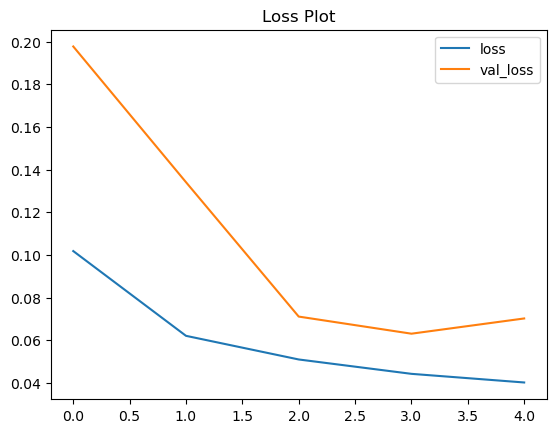

In [14]:
# print training and value loss
plt.plot(history_unet.history['loss'], label='loss')
plt.plot(history_unet.history['val_loss'], label='val_loss')
plt.title("Loss Plot")
plt.legend()

7/7 [==============================] - 12s 2s/step


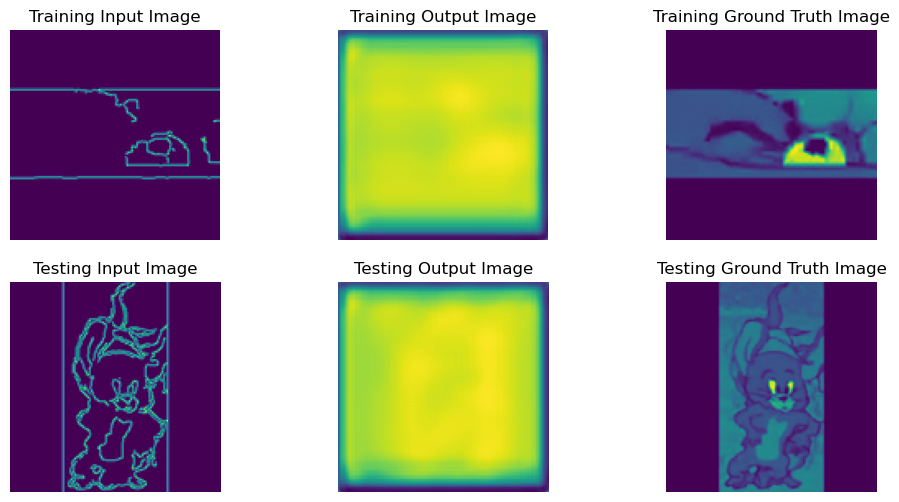

In [16]:
# Display images for testing

trainImageIndex = random.randint(0, len(x_train)-1)
testImageIndex = random.randint(0, len(x_test)-1)
train_output_image = unet_model.predict(x_train)[trainImageIndex]
test_output_image = unet_model.predict(x_test)[testImageIndex]

plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(np.array(x_train[trainImageIndex]))
plt.title("Training Input Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(np.array(train_output_image))
plt.title("Training Output Image")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(np.array(y_train[trainImageIndex]))
plt.title("Training Ground Truth Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(np.array(x_test[testImageIndex]))
plt.title("Testing Input Image")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(np.array(test_output_image))
plt.title("Testing Output Image")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(np.array(y_test[testImageIndex]))
plt.title("Testing Ground Truth Image")
plt.axis('off')

plt.show()

In [13]:
print(train_output_image.shape)

(128, 128)
